In [1]:
from Tools.Tools.Htt_trigSF import Htt_trigSFRDFProducer
import ROOT
import JupyROOT.helpers.utils
JupyROOT.helpers.utils.GetGeometryDrawer = lambda:None # magic fix to make ROOT faster
import cppyy
import numpy as np
import hist
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
import math
import correctionlib

Welcome to JupyROOT 6.24/07


In [2]:
sf_producer = Htt_trigSFRDFProducer(year=2018, isMC=True, isUL=True, ispreVFP=False, systematic_is_central=True, met_smear_tag_data="xycorr")

In [3]:
def get_sf(pairType, dau1_decayMode, dau1_pt, dau1_eta, dau2_decayMode, dau2_pt, dau2_eta):
    """ return 'trigSF',   'trigSF_single', 'trigSF_cross', 'trigSF_muUp trigSF_muDown trigSF_eleUp, trigSF_eleDown trigSF_DM0Up    trigSF_DM1Up     trigSF_DM10Up    trigSF_DM11Up, trigSF_DM0Down     trigSF_DM1Down     trigSF_DM10Down    trigSF_DM11Down trigSF_vbfjetUp trigSF_vbfjetDown
    """
    #                                                     isVBFtrigger
    return (cppyy.gbl.Htt_trigSF.get_scale_factors(pairType, False,
                            dau1_decayMode, dau1_pt, dau1_eta,
                            dau2_decayMode, dau2_pt, dau2_eta))

def printResult(res):
    print(f"SF={res.trigSF} passSingle={res.passSingle} passCross={res.passCross}")
    txt = ""
    for desc in  ["muUp", "muDown", "eleUp", "eleDown", "DM0Up",  "DM1Up", "DM10Up", "DM11Up", "DM0Down", "DM1Down", "DM10Down", "DM11Down"]:
        val = getattr(res, desc)
        if val != res.trigSF:
            txt += f"{desc}={val}, "
    print(txt)

In [4]:
pairType, pairType_str = 1, "etau"
dau1_decayMode=0
dau1_eta=0.1
dau1_pt=26.1

dau2_decayMode=0
dau2_eta=0.1
dau2_pt=36.

In [8]:
printResult(get_sf(pairType=pairType, dau1_decayMode=dau1_decayMode, dau1_eta=dau1_eta, dau2_decayMode=dau2_decayMode,  dau2_eta=dau2_eta,   dau1_pt=dau1_pt, dau2_pt=dau2_pt))

SF=0.9263343214988708 passSingle=0 passCross=1
eleUp=0.929547905921936, eleDown=0.9231207370758057, DM0Up=0.9555707573890686, DM0Down=0.8970978856086731, 


In [15]:
printResult(get_sf(pairType=pairType, dau1_decayMode=dau1_decayMode, dau1_eta=dau1_eta, dau2_decayMode=dau2_decayMode,  dau2_eta=dau2_eta,   dau1_pt=dau1_pt, dau2_pt=dau2_pt))

SF=0.890140208724708 (single=0.2267976223393443, cross=0.890140209994306)
eleUp=0.8898513190053238, eleDown=0.8904308412674177, DM0Up=0.9021261030889611, DM0Down=0.8777677370317378, 


In [5]:
cset = correctionlib.CorrectionSet.from_file("/cvmfs/cms.cern.ch/rsync/cms-nanoAOD/jsonpog-integration/POG/TAU/2018_UL/tau.json.gz")
c = cset["tau_trigger"]

In [6]:
def get_corrlib(*args):
    return (c.evaluate(*args, "nom"), c.evaluate(*args, "up"), c.evaluate(*args, "down"))
get_corrlib(dau2_pt, dau2_decayMode, pairType_str, "Medium", "sf") # pt, dm, trigtype, deeptau vsjet wp, corrtype (sf, eff_data, eff_mc), syst

(0.9307255, 0.96038723, 0.90106377)

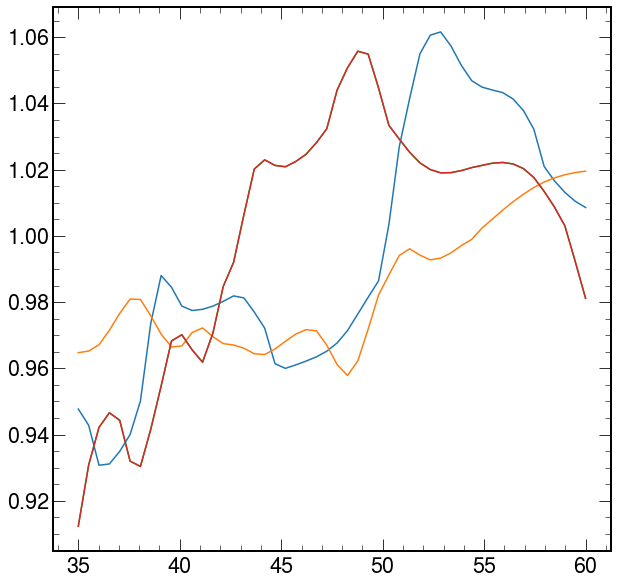

In [11]:
for DM in [0, 1, 10, 11]:
    plt.plot(np.linspace(35, 60, 50), [get_corrlib(x, DM, pairType_str, "Medium", "sf")[0] for x in np.linspace(35, 60, 50)]) 

In [10]:
eff_cross_ele_data, eff_cross_ele_mc = cppyy.gbl.Htt_trigSF.eTauTrgSF.get_EfficiencyData(dau1_pt, dau1_eta), cppyy.gbl.Htt_trigSF.eTauTrgSF.get_EfficiencyMC(dau1_pt, dau1_eta)
eff_cross_ele_data, eff_cross_ele_mc

(0.8504875302314758, 0.8574695587158203)

In [15]:
c.evaluate(dau2_pt, dau2_decayMode, pairType_str, "Medium", "eff_data", "up")

0.56546681

In [ ]:
 cppyy.gbl.Htt_trigSF.tauTrgSF_mutau.getEfficiencyData

In [11]:
effData, effMC = eff_cross_ele_data*c.evaluate(dau2_pt, dau2_decayMode, pairType_str, "Medium", "eff_data", "nom"), eff_cross_ele_mc*c.evaluate(dau2_pt, dau2_decayMode, pairType_str, "Medium", "eff_mc", "nom")
(effData/effMC) + (effData/effMC) * math.sqrt((eff_cross_ele_data*(c.evaluate(dau2_pt, dau2_decayMode, pairType_str, "Medium", "eff_data", "up")-c.evaluate(dau2_pt, dau2_decayMode, pairType_str, "Medium", "eff_data", "nom"))/effData)**2 + (eff_cross_ele_mc*(c.evaluate(dau2_pt, dau2_decayMode, pairType_str, "Medium", "eff_mc", "up")-c.evaluate(dau2_pt, dau2_decayMode, pairType_str, "Medium", "eff_mc", "nom"))/effMC)**2)

0.9217503037088612

In [12]:
ROOT.gInterpreter.Declare("""
double GetScaleFactorError(double effData, double effMC, double errData, double errMC) {
  // Compute absolute error on SF=effData/effMC propagating uncertainties. Taken from KLUB
  double SF_error = 0.;
  if (effData==0. || effMC==0.) {
    std::cout<<"WARNING in GetScaleFactorError(double effData, double effMC, double errData, double errMC): efficiency in data or MC = 0, can not calculate uncertainty on scale factor. Uncertainty set to 0. effData=" << effData << " effMC="<<effMC << std::endl;
    return 0.;
  }
  else {
    SF_error = pow((errData/effData),2) + pow((errMC/effMC),2);
    SF_error = pow(SF_error, 0.5)*(effData/effMC);
  }
  return SF_error;
}""")
ROOT.GetScaleFactorError(effData, effMC, c.evaluate(dau2_pt, dau2_decayMode, pairType_str, "Medium", "eff_data", "up")-c.evaluate(dau2_pt, dau2_decayMode, pairType_str, "Medium", "eff_data", "nom"), c.evaluate(dau2_pt, dau2_decayMode, pairType_str, "Medium", "eff_mc", "up")-c.evaluate(dau2_pt, dau2_decayMode, pairType_str, "Medium", "eff_mc", "nom"))

0.0302838966709281

input_line_144:2:8: error: redefinition of 'GetScaleFactorError'
double GetScaleFactorError(double effData, double effMC, double errData, double errMC) {
       ^
input_line_142:2:8: note: previous definition is here
double GetScaleFactorError(double effData, double effMC, double errData, double errMC) {
       ^


In [ ]:
SF_error = pow((errData/effData),2) + pow((errMC/effMC),2);
    SF_error = pow(SF_error, 0.5)*(effData/effMC);
GetScaleFactorError(Eff_data, Eff_MC, Eff_cross_ele_Data * (Eff_cross_tau_Data_Up-Eff_cross_tau_Data), ...)

example : etau (HLT_Ele24_eta2p1_WPTight_Gsf_LooseChargedIsoPFTau30_eta2p1_CrossL1)
ele_pt=26 (eta=0.1), tau_pt=36 (DM0)
ele leg SF=0.9919 +- 0.0039966202
tau leg 0.8959 (up 0.926 down 0.8657)
total 0.889 (up 0.918 down 0.859)

In [22]:
ROOT.Htt_trigSF.tauTrgSF_etau.getSF(dau2_pt, dau2_decayMode, 0) # SFProvider::getSF(float tau_pt, int tau_dm, int unc_scale=0 for nom, 1 for up, -1 for down)

0.8974477648735046

In [19]:
ROOT.Htt_trigSF.eTauTrgSF.get_ScaleFactor(dau1_pt, dau1_eta)

0.991857403667133

In [23]:
#nb neglecting electron leg uncert
ROOT.Htt_trigSF.tauTrgSF_etau.getSF(dau2_pt, dau2_decayMode, 0)*ROOT.Htt_trigSF.eTauTrgSF.get_ScaleFactor(dau1_pt, dau1_eta), ROOT.Htt_trigSF.tauTrgSF_etau.getSF(dau2_pt, dau2_decayMode, 1)*ROOT.Htt_trigSF.eTauTrgSF.get_ScaleFactor(dau1_pt, dau1_eta), ROOT.Htt_trigSF.tauTrgSF_etau.getSF(dau2_pt, dau2_decayMode, -1)*ROOT.Htt_trigSF.eTauTrgSF.get_ScaleFactor(dau1_pt, dau1_eta), 


(0.890140209994306, 0.9199968203861724, 0.8602835996024396)

In [25]:
ROOT.Htt_trigSF.tauTrgSF_etau.getSF(dau2_pt, dau2_decayMode, 1), ROOT.Htt_trigSF.tauTrgSF_etau.getEfficiencyData(dau2_pt, dau2_decayMode, 1)/ROOT.Htt_trigSF.tauTrgSF_etau.getEfficiencyMC(dau2_pt, dau2_decayMode, 1), 

(0.9275494813919067, 0.9095320554684434)

## Checking electron SF

In [3]:
c_ele = correctionlib.CorrectionSet.from_file("/cvmfs/cms.cern.ch/rsync/cms-nanoAOD/jsonpog-integration/POG/EGM/2018_UL/electron.json.gz")['UL-Electron-ID-SF']
c_ele.description # RecoAbove20, wp80iso

'These are the electron ID Scale Factors (nominal, up or down) for 2018 Ultra Legacy dataset. They are available for the cut-based and MVA IDs. They are dependent on the transverse momenta and pseudorapidity of the electron.'

In [4]:
c_ele.evaluate("2018", "sf", "Loose", 0., 22.) 

0.97268408536911

In [13]:
eta = 1.
c_ele.evaluate("2018", "sf", "wp80iso", eta, 22.) , c_ele.evaluate("2018", "sf", "wp80iso", eta, 22.), c_ele.evaluate("2018", "sf", "wp90iso", eta, 22.) , c_ele.evaluate("2018", "sf", "wp90noiso", eta, 22.) 

(0.9375, 0.9375, 0.962174952030182, 0.9528301954269408)

# checking electron scale&smearing

NameError: name 'uproot' is not defined